<a href="https://colab.research.google.com/github/abdulmukit98/Tensorflow-in-practice-specialization/blob/master/Deep_neural_network_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install tf-nightly-2.0-preview


In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.0.0-dev20191002


In [0]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [0]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [0]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
import tensorflow.keras.layers as tfl
model = tf.keras.models.Sequential([
      tfl.Dense(10, input_shape=[window_size], activation='relu'),
      tfl.Dense(10, activation='relu'),
      tfl.Dense(1)
])
model.compile(loss='mse',
              optimizer=tf.keras.optimizers.SGD( lr=1e-6, momentum=0.9))
model.fit(dataset, epochs=100)

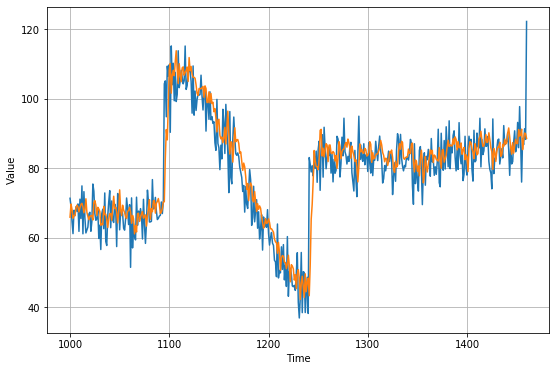

In [13]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(
      series[time:time + window_size][np.newaxis]
  ))
forecast = forecast[split_time - window_size:]
results = np.array(forecast)[:, 0, 0]

plt.figure(figsize=(9,6))
plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [14]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

5.1797395

In [0]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20)
)
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss='mse', optimizer=optimizer)
history = model.fit(dataset, epochs=100, callbacks=[lr_schedule])

[1e-08, 0.001, 0, 3]

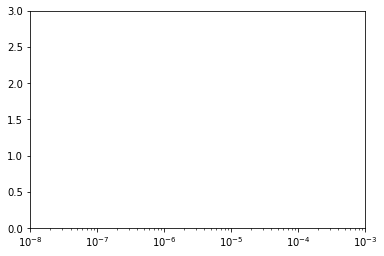

In [20]:
lrs = 1e-8 * (10 ** (np.arange(100) / 20))
plt.semilogx(lrs, history.history['loss'])
plt.axis([1e-8, 1e-3, 0, 3])

In [0]:
window_size = 30
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1)
])

optimizer = tf.keras.optimizers.SGD(lr=8e-6, momentum=0.9)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, epochs=500, verbose=0)

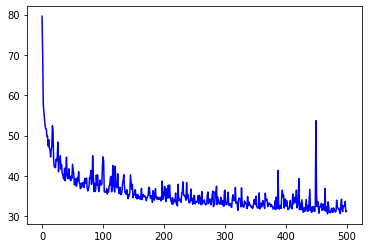

In [22]:
loss = history.history['loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.show()

[47.39251406954736, 48.980334299618434, 46.84345431770246, 46.64862643369695, 44.71203373387917, 46.398607769209086, 47.32872516199485, 52.436313558362194, 51.266562534607566, 43.92115870603581, 42.313850041025695, 42.18812469797036, 42.036851076735665, 44.111812135362136, 43.70186391614147, 44.86189726210132, 48.39970395589612, 41.04131608156814, 43.56081159925952, 43.751260895090006, 44.980221604809316, 41.67561845287834, 42.82975872079122, 40.66554275984617, 40.337599787761256, 39.44256077206012, 39.18139851363664, 41.917435549706525, 38.76108291075402, 41.10362758243207, 44.649552276454024, 40.43047980082404, 39.33221511250919, 39.55766819039571, 41.75632727318203, 39.3458424833632, 39.52914579725757, 38.793062693802355, 40.02814550498097, 39.39856382546966, 42.89076560108932, 41.675043188665335, 40.48725525374265, 37.81676742711018, 38.38531887408384, 39.330464848783826, 37.446986459948356, 37.704268441741, 39.60433091625725, 38.84579112259383, 41.05344759361031, 38.3023409066741,

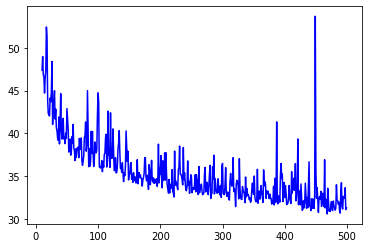

In [23]:
loss = history.history['loss']
epochs = range(10, len(loss))
plot_loss = loss[10:]
print(plot_loss)
plt.plot(epochs, plot_loss, 'b', label='Training Loss')
plt.show()

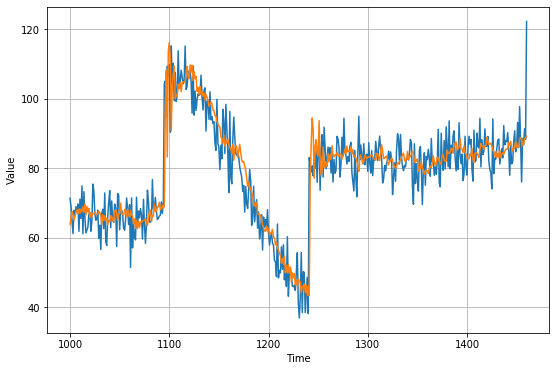

In [25]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]

plt.figure(figsize=(9,6))
plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [26]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

4.8024006